In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.colors as mcolors
import sympy as sym
from scipy.integrate import solve_bvp # import the TPBVP solver

Solver success:  True


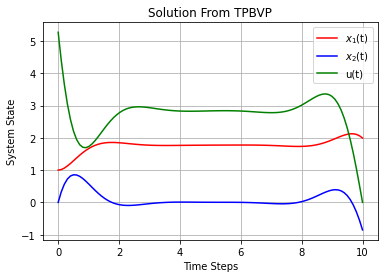

In [10]:
# initialize parameters
N = 100
T = 10.0
k = 1.6
d1 = 2.0
d2 = 0.1
c1 = 100.0
c2 = 0.0 #weight on terminal velocity equals zero in all code below 
#not included in any equations of motion#
xref = 2.0 #desired position at the end of the time horizon
x0 = np.array([1., 0.])
t_axis = np.linspace(T, 0, N) # forward time steps
t_axis2 = np.linspace(0, T, N) # backward time steps

# initial guess for the time series (x,p)
z = np.zeros((4, N))

# TPBVP system dynamics (in vector form)
def fun(t, z):
    return np.vstack((z[1], -k*z[0]-(1/d2)*z[3], -d1*z[0]+k*z[3]+d1*xref, -1.0*z[2]))

# # boundary condition specification based on usage of solve_bvp, see scipy documentation
# def bc(za, zb):
#     xT = zb[0:2]
#     p1 = np.vstack((c1*(xT[0]-xref), c2*xT[1]))
#     return np.array([za[0]-x0[0], za[1]-x0[1], zb[2]-p1[0], zb[3]-p1[1]])

# boundary condition specification based on usage of solve_bvp, see scipy documentation
def bc(za, zb):
    xT = zb[0:2]
    p1 = np.array([c1 * (xT[0] - xref), c2 * xT[1]])
    return np.hstack((za[0]-x0[0], za[1]-x0[1], zb[2:4]-p1))

# solve TPBVP
res = solve_bvp(fun, bc, t_axis2, z)
x1 = res.sol(t_axis2)[0:2]
p1 = res.sol(t_axis2)[2:4]
u1 = -1/d2 * p1[1]
print("Solver success: ", res.success)

# plot
fig = plt.figure()
ax = plt.gca()
ax.plot(t_axis2, x1[0,:], 'r')
ax.plot(t_axis2, x1[1,:], 'b')
ax.plot(t_axis2, u1.reshape(N), 'g')
ax.legend(['$x_1$(t)', '$x_2$(t)', 'u(t)'])
ax.set_title("Solution From TPBVP")
ax.set_xlabel("Time Steps")
ax.set_ylabel("System State")
plt.grid()
plt.show()
plt.close()


In [26]:
# Problem 2

def f(x):
    """given function"""
    return (0.26 * ((x[0]**2) + (x[1]**2))) - (0.46 * (x[0] * x[1]))

    
def f_grad(x):
    """calculates the gradient of the f function above"""
    dJdx1 = (0.52 * x[0]) - (0.46 * x[1])
    dJdx2 = (0.52 * x[1]) - (0.46 * x[0])

    return np.array([dJdx1, dJdx2])

def armijo(x, gamma_0, alpha, beta):
    """armijo line search"""
    gamma = gamma_0
    z = -1*f_grad(x)

    while f(x + (gamma*z)) > (f(x) + (alpha * gamma * np.dot(f_grad(x).T, z))):
        gamma *= beta

    x += gamma * z

    return x

def compute_z(X, Y):
    """Compute function values Z"""
    Z = np.zeros_like(X)  # Initialize array for function values
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = f([X[i, j], Y[i, j]])
    return Z

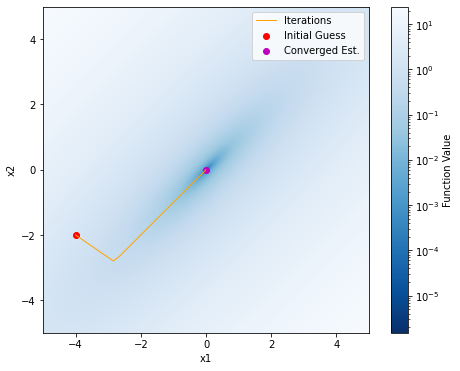

In [34]:
# Plot problem 2

# Establish all variables
x_range = np.linspace(-5, 5, 1000)
y_range = np.linspace(-5, 5, 1000)

X, Y  = np.meshgrid(x_range, y_range)
x_input = [X, Y]
z_mat = compute_z(X, Y)

n_iter = 100
gamma_init = 1.0
alpha = 10e-4
beta = 0.5
init_guess = np.array([-4.0, -2.0])

x_traj = np.zeros(shape=(n_iter + 1, 2))
x_traj[0, :] = init_guess

# Run through all iterations
for i in range(n_iter):
    x_traj[i+1, :] = armijo(init_guess, gamma_init, alpha, beta)

# Create the plot
plt.figure(figsize=(8, 6))
plt.imshow(z_mat, origin="lower", extent=[-5, 5, -5, 5], cmap="Blues_r", norm=mcolors.LogNorm())
plt.colorbar(label='Function Value')
plt.plot(x_traj[:, 0], x_traj[:, 1], color="orange", linewidth=1, label="Iterations")
plt.scatter(x_traj[0, 0], x_traj[0, 1], color="r", label="Initial Guess")
plt.scatter(x_traj[n_iter, 0], x_traj[n_iter, 1], color="m", label="Converged Est.")
plt.legend(loc='upper right')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()